<a href="https://colab.research.google.com/github/GVSU-CIS635/term-project-proposal-d-miner/blob/main/D_Miners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
pip install xlrd

In [105]:
pip install pingouin

In [106]:
from operator import mod
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import csv
import pingouin as pg
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from seaborn import heatmap
import seaborn as sns

Loading Data

In [107]:
from re import X

# Getting data from different sources and creating Dataframes

CSVData = pd.read_csv('https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v7.csv')
CSVData = pd.DataFrame(CSVData)
feature_grid = pd.read_excel('https://www.eia.gov/consumption/residential/data/2020/xls/RECS%202020%20Codebook%20for%20Public%20File%20-%20v7.xlsx', header=1)
feature_grid = pd.DataFrame(feature_grid)
main_features= CSVData.columns
print(len(main_features))



799


### Gets the sections and displays them in a grid

Early Stage Feature Selection

In [108]:
# Gets the section of variables that contain Categorical Data

selected_sections = ['GEOGRAPHY', 'ADMIN']

# Converts the target data into binary by converting the value by binning the values based on Median
Y = 'KWHbins'

CSVData[Y] = pd.qcut(CSVData['KWH'], q=2, labels=[0, 1])
CSVData[Y] = CSVData[Y].astype(int)



display(feature_grid)


features = feature_grid[feature_grid['Section'].isin(selected_sections)]['Variable'].tolist()


display(features)

,Variable,Type,Description and Labels,Response Codes,Section
0,DOEID,Num,Unique identifier for each respondent,100001-118496,ADMIN
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
2,DIVISION,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY
3,STATE_FIPS,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY
4,state_postal,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY
...,...,...,...,...,...
794,EVCHRGDLR,Num,"EV is charged at car dealerships, not imputed","1 Yes\n0 No\n-2 Not applicable\n""."" or blank M...",ENERGY BILLS
795,EVCHRGHWY,Num,"EV is charged at highway rest stops, not imputed","1 Yes\n0 No\n-2 Not applicable\n""."" or blank M...",ENERGY BILLS
796,EVCHRGOTH,Num,EV is charged at other public charging station...,"1 Yes\n0 No\n-2 Not applicable\n""."" or blank M...",ENERGY BILLS
797,EVHOMEAMT,Num,"Portion of EV charging done at home, not imputed",1 All at home (100%)\n2 Almost all at home (80...,ENERGY BILLS


['DOEID',
 'REGIONC',
 'DIVISION',
 'STATE_FIPS',
 'state_postal',
 'state_name',
 'BA_climate',
 'IECC_climate_code',
 'UATYP10']

Feature Selection of numeric variables based on missing Data

In [109]:
# Selected sections that had numeric columns with very few missing or not application values


iamb_sections = ['WEATHER', 'YOUR HOME']
iamb_features = feature_grid[feature_grid['Section'].isin(iamb_sections)]['Variable'].tolist()
iamb_features.append('KWHbins')
display(iamb_features)


# Got rid of the columns with a lot of missing data

none_values = [0,-2]

for feature in main_features:
  if len(CSVData[CSVData[feature].isin(none_values)]) > 10000 :
   main_features = main_features.drop(feature)

# Got the list of column that can be used for our IAMB function

blanket = [var for var in iamb_features if var in main_features]
blanket.append(Y)


print(CSVData[blanket].dtypes)
display(CSVData[Y].value_counts())

['HDD65',
 'CDD65',
 'HDD30YR_PUB',
 'CDD30YR_PUB',
 'TYPEHUQ',
 'CELLAR',
 'CRAWL',
 'CONCRETE',
 'BASEOTH',
 'BASEFIN',
 'ATTIC',
 'ATTICFIN',
 'STORIES',
 'PRKGPLC1',
 'SIZEOFGARAGE',
 'KOWNRENT',
 'YEARMADERANGE',
 'BEDROOMS',
 'NCOMBATH',
 'NHAFBATH',
 'OTHROOMS',
 'TOTROOMS',
 'STUDIO',
 'WALLTYPE',
 'ROOFTYPE',
 'HIGHCEIL',
 'DOOR1SUM',
 'WINDOWS',
 'TYPEGLASS',
 'ORIGWIN',
 'WINFRAME',
 'TREESHAD',
 'ADQINSUL',
 'DRAFTY',
 'UGASHERE',
 'SWIMPOOL',
 'MONPOOL',
 'POOLPUMP',
 'FUELPOOL',
 'RECBATH',
 'MONTUB',
 'FUELTUB',
 'SQFTEST',
 'SQFTRANGE',
 'SQFTINCB',
 'SQFTINCA',
 'SQFTINCG',
 'TOTSQFT_EN',
 'TOTHSQFT',
 'TOTCSQFT',
 'ZADQINSUL',
 'ZATTIC',
 'ZATTICFIN',
 'ZBASEFIN',
 'ZBASEOTH',
 'ZBEDROOMS',
 'ZCELLAR',
 'ZCONCRETE',
 'ZCRAWL',
 'ZDOOR1SUM',
 'ZDRAFTY',
 'ZFUELPOOL',
 'ZFUELTUB',
 'ZHIGHCEIL',
 'ZKOWNRENT',
 'ZMONPOOL',
 'ZMONTUB',
 'ZNCOMBATH',
 'ZNHAFBATH',
 'ZORIGWIN',
 'ZOTHROOMS',
 'ZPOOLPUMP',
 'ZPRKGPLC1',
 'ZRECBATH',
 'ZROOFTYPE',
 'ZSIZEOFGARAGE',
 'ZSQFTEST'

HDD65              int64
CDD65              int64
HDD30YR_PUB        int64
CDD30YR_PUB        int64
TYPEHUQ            int64
ATTIC              int64
STORIES            int64
PRKGPLC1           int64
SIZEOFGARAGE       int64
KOWNRENT           int64
YEARMADERANGE      int64
BEDROOMS           int64
NCOMBATH           int64
OTHROOMS           int64
TOTROOMS           int64
WALLTYPE           int64
ROOFTYPE           int64
HIGHCEIL           int64
DOOR1SUM           int64
WINDOWS            int64
TYPEGLASS          int64
ORIGWIN            int64
WINFRAME           int64
TREESHAD           int64
ADQINSUL           int64
DRAFTY             int64
UGASHERE           int64
SQFTEST            int64
SQFTRANGE          int64
TOTSQFT_EN         int64
TOTHSQFT           int64
TOTCSQFT           int64
DBT1             float64
DBT99            float64
GWT              float64
KWHbins            int64
dtype: object


,count
KWHbins,
1,9248
0,9248


### Creates the IAMB Algorithm formula

In [110]:
def iamb(data, target, alpha=0.05):

    # Initialize the Markov Blanket (MB) for the target as an empty list
    MB_Y = []

    # Initialize the set of remaining variables (excluding the target variable)
    remaining_variables = set(data.columns) - {target}

    while remaining_variables:
        max_pval = float('inf')  # Initialize the max p-value as infinity
        best_variable = None

        # Loop through the remaining variables to find the best one
        for variable in remaining_variables:
            # Compute the partial correlation between the target and the variable
            # Conditioning on the current Markov blanket (MB_Y)
            partial_corr = pg.partial_corr(data=data, x=target, y=variable, covar=MB_Y)

            # If the p-value is smaller than alpha and larger than the current max p-value
            pval = partial_corr['p-val'].values[0]
            if pval < alpha and pval < max_pval:
                max_pval = pval
                best_variable = variable

        # If a best variable was found that satisfies the significance condition
        if best_variable:
            MB_Y.append(best_variable)
            remaining_variables.remove(best_variable)
        else:
            # If no variable satisfies the p-value condition, break out of the loop
            break

    return MB_Y

Select the numeric features

In [111]:
# get the list of numeric features after running the IAMB function

markov_blanket = iamb(CSVData[blanket], Y)


display(len(markov_blanket))
display(markov_blanket)

display(CSVData[markov_blanket])

# finalised the dataset that contains IAMB columns
iamb_csvdata = CSVData[markov_blanket]

22

['NCOMBATH',
 'TYPEHUQ',
 'CDD30YR_PUB',
 'TOTCSQFT',
 'UGASHERE',
 'TOTROOMS',
 'DRAFTY',
 'SQFTRANGE',
 'TOTSQFT_EN',
 'KOWNRENT',
 'CDD65',
 'DBT1',
 'BEDROOMS',
 'GWT',
 'DBT99',
 'HDD30YR_PUB',
 'TOTHSQFT',
 'STORIES',
 'OTHROOMS',
 'TREESHAD',
 'WINFRAME',
 'TYPEGLASS']

,NCOMBATH,TYPEHUQ,CDD30YR_PUB,TOTCSQFT,UGASHERE,TOTROOMS,DRAFTY,SQFTRANGE,TOTSQFT_EN,KOWNRENT,...,BEDROOMS,GWT,DBT99,HDD30YR_PUB,TOTHSQFT,STORIES,OTHROOMS,TREESHAD,WINFRAME,TYPEGLASS
0,3,2,1027,2100,1,8,3,6,2100,1,...,4,58.5,21.6,4451,2100,1,4,1,3,2
1,1,5,1305,590,1,3,3,1,590,2,...,1,57.2,16.1,4429,590,-2,2,0,1,2
2,1,5,1010,900,1,4,4,3,900,2,...,1,58.5,21.6,4500,900,-2,3,0,2,1
3,2,2,1653,2100,1,9,4,6,2100,1,...,2,61.5,25.1,3229,2100,2,7,1,3,2
4,1,5,1059,800,1,3,3,3,800,2,...,1,55.9,13.0,4896,800,-2,2,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,2,3,1190,1500,1,5,4,4,1500,1,...,3,54.9,17.9,4547,1500,2,2,0,3,2
18492,1,2,186,1530,0,5,3,5,3070,1,...,3,39.1,-8.9,9862,3070,1,2,0,1,2
18493,2,1,4047,900,1,5,4,5,1500,1,...,3,78.6,42.0,672,0,-2,2,0,1,1
18494,3,2,2295,3000,0,9,3,8,3000,1,...,3,70.4,31.5,1752,3000,2,6,1,3,2


### Processes the data through an encoder

In [112]:
# select the categorical features that we needed for the model

categorical_features = ['REGIONC', 'DIVISION', 'BA_climate', 'UATYP10']

# convert Categorical features into Numerical features using OneHotEncoder
enc_data = CSVData[categorical_features]
display(enc_data)

enc= OneHotEncoder(dtype=np.int64)
enc_data_fit = enc.fit_transform(enc_data).toarray()
enc_data_fit = pd.DataFrame(enc_data_fit)
enc_data_fit.columns = enc.get_feature_names_out()
display(enc_data_fit)

,REGIONC,DIVISION,BA_climate,UATYP10
0,WEST,Mountain South,Mixed-Dry,U
1,SOUTH,West South Central,Mixed-Humid,U
2,WEST,Mountain South,Mixed-Dry,U
3,SOUTH,South Atlantic,Mixed-Humid,U
4,NORTHEAST,Middle Atlantic,Mixed-Humid,U
...,...,...,...,...
18491,SOUTH,South Atlantic,Mixed-Humid,U
18492,NORTHEAST,New England,Very-Cold,R
18493,SOUTH,West South Central,Hot-Humid,U
18494,SOUTH,South Atlantic,Hot-Humid,U


,REGIONC_MIDWEST,REGIONC_NORTHEAST,REGIONC_SOUTH,REGIONC_WEST,DIVISION_East North Central,DIVISION_East South Central,DIVISION_Middle Atlantic,DIVISION_Mountain North,DIVISION_Mountain South,DIVISION_New England,...,BA_climate_Hot-Dry,BA_climate_Hot-Humid,BA_climate_Marine,BA_climate_Mixed-Dry,BA_climate_Mixed-Humid,BA_climate_Subarctic,BA_climate_Very-Cold,UATYP10_C,UATYP10_R,UATYP10_U
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
18492,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
18493,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
18494,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


Creating Test and Train Split

In [113]:
# split the data into training data and testing data after combing the numerical features from markov blanker and the categorical features that were converted into numeric data using OneHotEncoder

Y_data = CSVData[Y]
X_data = pd.concat([CSVData[markov_blanket], enc_data_fit], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.3)


print(X_train.dtypes)

NCOMBATH                         int64
TYPEHUQ                          int64
CDD30YR_PUB                      int64
TOTCSQFT                         int64
UGASHERE                         int64
TOTROOMS                         int64
DRAFTY                           int64
SQFTRANGE                        int64
TOTSQFT_EN                       int64
KOWNRENT                         int64
CDD65                            int64
DBT1                           float64
BEDROOMS                         int64
GWT                            float64
DBT99                          float64
HDD30YR_PUB                      int64
TOTHSQFT                         int64
STORIES                          int64
OTHROOMS                         int64
TREESHAD                         int64
WINFRAME                         int64
TYPEGLASS                        int64
REGIONC_MIDWEST                  int64
REGIONC_NORTHEAST                int64
REGIONC_SOUTH                    int64
REGIONC_WEST             

### Decision Tree Grid Search

In [114]:
# Decision Tree Grid Search
dt_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
model_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = model_tree, param_grid = dt_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params)
print(best_estimator)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=5)


### Logistic Regression Grid Search

In [115]:
# Logistic Regression Grid Search


lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model_log = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(estimator = model_log, param_grid = lr_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params)
print(best_estimator)

{'C': 0.1}
LogisticRegression(C=0.1, solver='liblinear')


### Gaussian Naive Bayes Grid Search

In [116]:
# Gaussian Naive Bayes Grid Search
gnb_param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
model_nb = GaussianNB()
grid_search = GridSearchCV(estimator = model_nb, param_grid = gnb_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params)
print(best_estimator)

{'var_smoothing': 4.328761281083061e-09}
GaussianNB(var_smoothing=4.328761281083061e-09)


### KNN Grid Search

In [117]:
# KNN Grid Search


knn_param_grid = {'n_neighbors': np.arange(1, 25)}
model_knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = model_knn, param_grid = knn_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'n_neighbors': 21}
KNeighborsClassifier(n_neighbors=21)


Define Classifiers with the best Hyperparameters

In [118]:
#Define Classifiers with best Hyperparameter

model_knn= KNeighborsClassifier(n_neighbors=19)
model_nb = GaussianNB(var_smoothing=5.337)
model_tree = DecisionTreeClassifier(criterion ='gini', max_depth=5, min_samples_leaf=4)
model_log = LogisticRegression(C=1, solver='liblinear')

# Creates the model list and plots the models in an ROC Curve

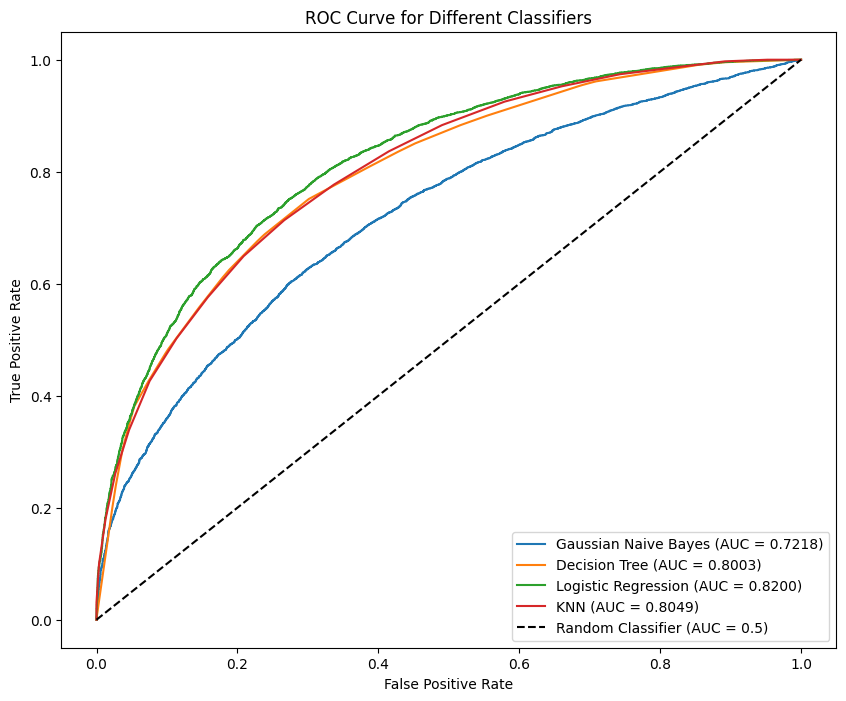

In [119]:
from sklearn.metrics import roc_curve, auc

# Initialize a plot
plt.figure(figsize=(10, 8))

# Function to plot ROC curve
def plot_roc_curve(model, model_name, X, y):
    # Get predicted probabilities for the positive class
    model.fit(X_train, Y_train)
    y_prob = model.predict_proba(X)[:, 1]  # Only get probabilities for the positive class

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Evaluate and plot ROC curve for each model
plot_roc_curve(model_nb, 'Gaussian Naive Bayes', X_train, Y_train)
plot_roc_curve(model_tree, 'Decision Tree', X_train, Y_train)
plot_roc_curve(model_log, 'Logistic Regression', X_train, Y_train)
plot_roc_curve(model_knn, 'KNN', X_train, Y_train)

# Plot the diagonal line (random classifier: AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# Labels and title
plt.title('ROC Curve for Different Classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show plot
plt.show()

### Graph the precision, recall and f1 score for all models

F1 Score for KNN: 0.7064220183486238
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2827
           1       0.71      0.71      0.71      2722

    accuracy                           0.71      5549
   macro avg       0.71      0.71      0.71      5549
weighted avg       0.71      0.71      0.71      5549

[[2024  803]
 [ 797 1925]]


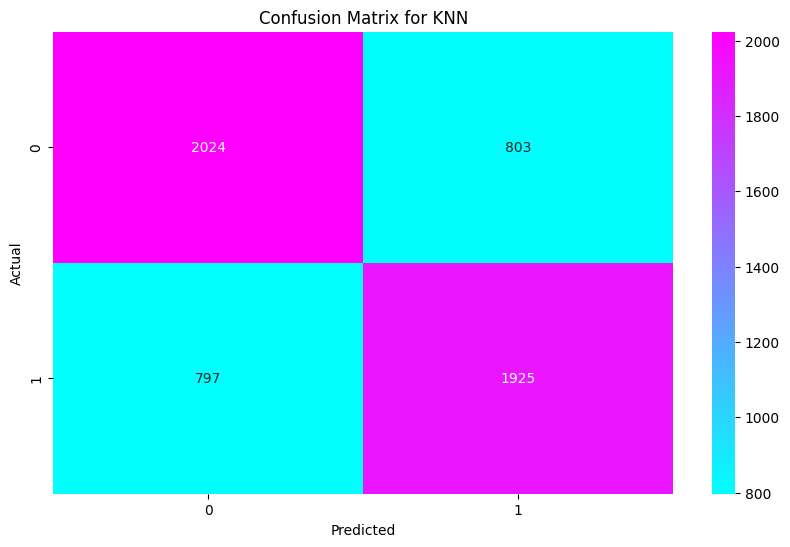


F1 Score for Logistic Regression: 0.7364607860894765
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2827
           1       0.73      0.75      0.74      2722

    accuracy                           0.74      5549
   macro avg       0.74      0.74      0.74      5549
weighted avg       0.74      0.74      0.74      5549

[[2061  766]
 [ 689 2033]]


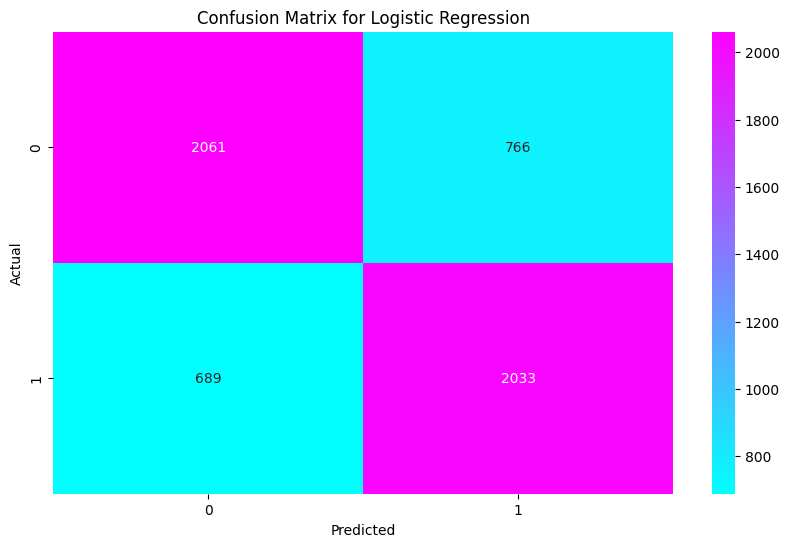


F1 Score for Decision Tree: 0.725609756097561
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      2827
           1       0.71      0.74      0.73      2722

    accuracy                           0.72      5549
   macro avg       0.72      0.72      0.72      5549
weighted avg       0.73      0.72      0.72      5549

[[1996  831]
 [ 699 2023]]


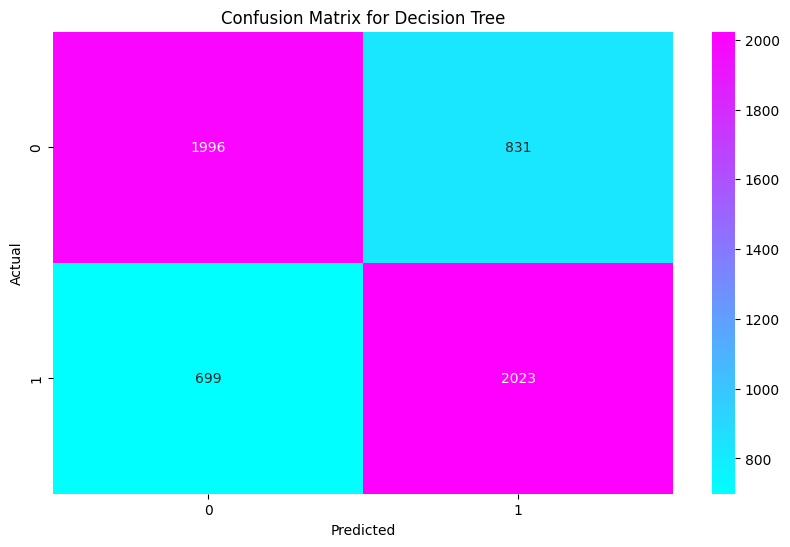


F1 Score for Gaussian Naive Bayes: 0.5687458081824279
              precision    recall  f1-score   support

           0       0.62      0.83      0.71      2827
           1       0.73      0.47      0.57      2722

    accuracy                           0.65      5549
   macro avg       0.67      0.65      0.64      5549
weighted avg       0.67      0.65      0.64      5549

[[2348  479]
 [1450 1272]]


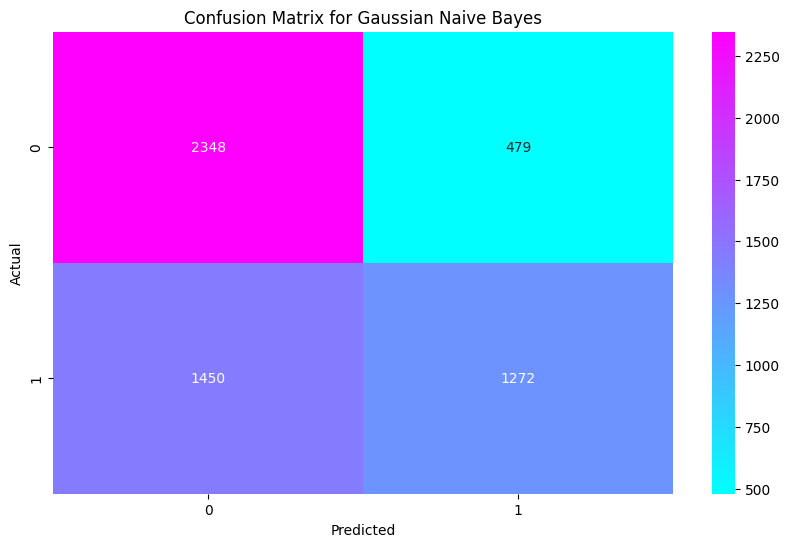

In [120]:
# Graph the f1 scores for all models

f1_scores = {}
for model_name, model in model_list.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(Y_test, y_pred)
    f1_scores[model_name] = f1
    print(f'F1 Score for {model_name}: {f1}')
    print(classification_report(Y_test, y_pred))
    print(confusion_matrix(Y_test, y_pred))

    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(Y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='cool')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print()



In [121]:
# DEfine Grid with all the Metrics

Metrics_grid = {
    'Classifiers': [],
    'Accuracy (mean ± std)': [],
    'F1 Score (mean ± std)': [],
    'AUC-ROC (mean ± std)': []
}


# Define function to get dataframe with scores for each classifier

def metrics_table( classifier, classifer_name, x, y):



  accuracy_score = cross_val_score(classifier, x, y, cv=5, scoring='accuracy')
  f1_score = cross_val_score(classifier, x, y, cv=5, scoring='f1_weighted')
  roc_auc_score = cross_val_score(classifier, x, y, cv=5, scoring='roc_auc')

  Metrics_grid['Classifiers'].append(classifer_name)
  Metrics_grid['Accuracy (mean ± std)'].append(f'{accuracy_score.mean():.3f} ± {accuracy_score.std():.3f}')
  Metrics_grid['F1 Score (mean ± std)'].append(f'{f1_score.mean():.3f} ± {f1_score.std():.3f}')
  Metrics_grid['AUC-ROC (mean ± std)'].append(f'{roc_auc_score.mean():.3f} ± {roc_auc_score.std():.3f}')

  return Metrics_grid



#execute function

metrics_table(model_knn, 'KNN', X_train, Y_train)
metrics_table(model_log, 'Logistic Regression', X_train, Y_train)
metrics_table(model_tree, 'Decision Tree', X_train, Y_train)
metrics_table(model_nb, 'Gaussian Naive Bayes', X_train, Y_train)

# Display Dataframe

Metrics_grid = pd.DataFrame(Metrics_grid)
display(Metrics_grid)



,Classifiers,Accuracy (mean ± std),F1 Score (mean ± std),AUC-ROC (mean ± std)
0,KNN,0.689 ± 0.010,0.689 ± 0.010,0.758 ± 0.012
1,Logistic Regression,0.736 ± 0.005,0.736 ± 0.005,0.818 ± 0.005
2,Decision Tree,0.712 ± 0.005,0.712 ± 0.005,0.783 ± 0.005
3,Gaussian Naive Bayes,0.651 ± 0.009,0.644 ± 0.010,0.722 ± 0.004
